In [124]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel, BertConfig
from core.analysis import annotate_mtx

<Figure size 432x288 with 0 Axes>

In [6]:
model_config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states = True,
                                          output_attentions = True)

In [8]:
model = BertModel.from_pretrained('bert-base-uncased', config = model_config)

In [204]:
def extract_attn(sentence, target):
    data = preprocess(sentence, target)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenized_text = tokenizer.tokenize(sentence)
    indexed_tokens = data[0]
    segments_ids = data[1]
    target_token_index = data[2]

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    with torch.no_grad():
        outputs = model(tokens_tensor)
    attention = outputs[3]
    return attention, tokenized_text

In [189]:
def plot_attn_mtx(sentence, target):
    #This is attention at the last layer
    attention, tokenized_text = extract_attn(sentence, target)
    last_attn = attention[11]
    summed_heads = torch.sum(last_attn, dim = 1) #Summed the results from all the attention heads to get this
    attn_mtx = summed_heads[0][1:-1, 1:-1]
    fig = plt.figure(figsize = (10, 8))
    ax = plt.subplot()
    im = plt.imshow(attn_mtx)
    annotate_mtx(attn_mtx.numpy(), im, ax, tokenized_text, write_text = True)

In [190]:
def format_attention(attention):
    #From https://github.com/jessevig/bertviz/blob/master/bertviz/util.py
    squeezed = []
    for layer_attention in attention:
        # 1 x num_heads x seq_len x seq_len
        if len(layer_attention.shape) != 4:
            raise ValueError("The attention tensor does not have the correct number of dimensions. Make sure you set "
                             "output_attentions=True when initializing your model.")
        squeezed.append(layer_attention.squeeze(0))
    # num_layers x num_heads x seq_len x seq_len
    return torch.stack(squeezed)


In [205]:
s1_attn, tkns = extract_attn("The waiter served food at the table", "table")
output = format_attention(s1_attn)

In [207]:
output[0][0][0]

tensor([0.0635, 0.1441, 0.0234, 0.0634, 0.0558, 0.1232, 0.1666, 0.0484, 0.3116])

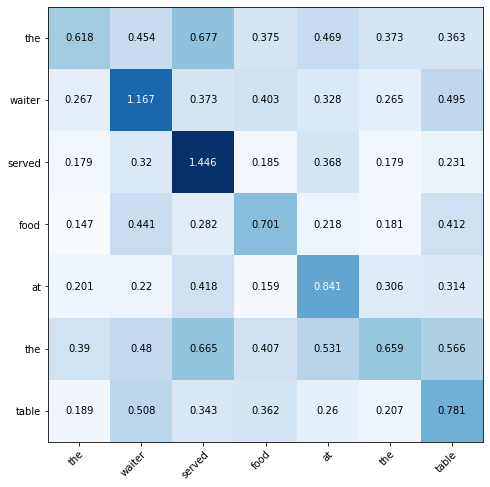

In [192]:
plot_attn_mtx("The waiter served food at the table", "table")

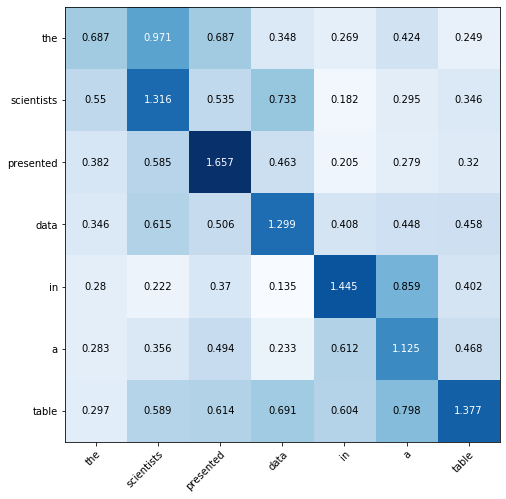

In [193]:
plot_attn_mtx("The scientists presented data in a table", "table")

Trying to replicate results from Clark et al 2019

In [245]:
s1 = "Pentanodes albofasciatus is a species of beetle in the family Cerambycidae."
s2 = "It was described by Fisher in 1932."
s1 = "[CLS]" + s1 + "[SEP]"
s2 = s2 + "[SEP]"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
s1_toks = tokenizer.tokenize(s1)
s2_toks = tokenizer.tokenize(s2)
bert_tokens = s1_toks + s2_toks
bert_input = tokenizer.convert_tokens_to_ids(bert_tokens)

In [246]:
tokens_tensor = torch.tensor([bert_input])
with torch.no_grad():
    outputs = model(tokens_tensor)
attn = format_attention(outputs[3])


In [281]:
def query_attention(attn, tokens, layer, target_token):
    #attn is a Pytorch tensor with dimensions Layers x Heads x Token x Words token attends to
    token_index = tokens.index(target_token)
    
    all_heads = attn[layer, :, token_index]
    return np.mean(all_heads.numpy(), axis = 0)
